In [1]:
using Omega
using Omega.Inference: ReplicaAlg
using Plots
import Statistics
using Random
include("viz.jl")

Main.##384.vizscene

Consider a projectile launched at an angle θ with initial velocity vo on a level plane
We know the  equations of motion are:

\begin{equation}
x(t) = v_0 \cos \theta t\\
y(t) = v_0 \sin \theta t - \frac{1}{2}gt^2
\end{equation}

Launch point and gravity are constants but we have uncertainty over velocity,

In [2]:
const v0 = normal(10, 1)
const u0 = constant((0.0, 0.0))
const g = constant(9.81)
const θ = π/4 + normal(0, 1)

11571:Omega.reifyapply(+, 0.7853981633974483, Normal)::Float64

We will simulate step by step, which preserves causal order

In [3]:
"Simulate projectile motion for `nsteps` with `Δt`"
function simulate(u0, v0, θ, g; maxsteps = 10000, Δt = 0.01)
  t = 0.0
  series = [u0]
  for i = 1:(maxsteps - 1)
    x = v0 * t * cos(θ)
    y = v0 * t * sin(θ) - 0.5 * g * t^2
    if y < 0
      break
    end
    push!(series, (x, y))
    t += Δt
  end
  series
end

Main.##384.simulate

`series` is a random variable over position of the projectile

In [4]:
const series = lift(simulate)(u0, v0, θ, g)

11572:Omega.reifyapply(Main.##384.simulate, getfield(Omega, Symbol("##1#2")){Tuple{Float64,Float64}}((0.0, 0.0)), Normal, Omega.reifyapply, getfield(Omega, Symbol("##1#2")){Float64}(9.81))::Array{Tuple{Float64,Float64},1}

### But-For causality
Next we will add a (yellow) ball to the scene, which the projective may or may not hit.

We assume a ball of constant radius and position

In [5]:
const ball_radius = constant(0.5)
const ball_pos = constant((8.0, 0.25))

11574:getfield(Omega, Symbol("##1#2")){Tuple{Float64,Float64}}((8.0, 0.25))()::Tuple{Float64,Float64}

We can simulate projectile samples from the prior

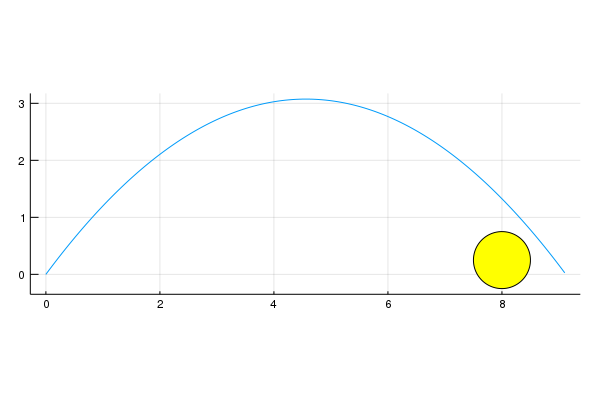

In [6]:
series_, ball_pos_, ball_radius_ = rand((series, ball_pos, ball_radius))
vizscene(series_, ball_pos_, ball_radius_)

Next we do simple collision detection to see if the projectile intersects the ball

In [7]:
"Is this position inside the ball"
isinside(pos, ball_pos, ball_radius) = sqrt(sum((pos .- ball_pos).^2)) <ₛ ball_radius

"Does the projectile hit the ball?"
function projectile_hits_(ω)
  series_ = series(ω)
  ball_pos_, ball_radius_ = ball_pos(ω), ball_radius(ω)
  hits_vs_t = map(pos -> isinside(pos, ball_pos_, ball_radius_), series_)
  anyₛ(hits_vs_t)
end

const projectile_hits = ciid(projectile_hits_)

11577:Main.##384.projectile_hits_()::Omega.Soft.DualSoftBool{Omega.Soft.SoftBool{Float64}}

The prior probability that the projectile hits the ball can be approximated:

In [8]:
Statistics.mean(Bool.(rand(projectile_hits, 1000)))

0.112

Find a world where the conditions are true

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


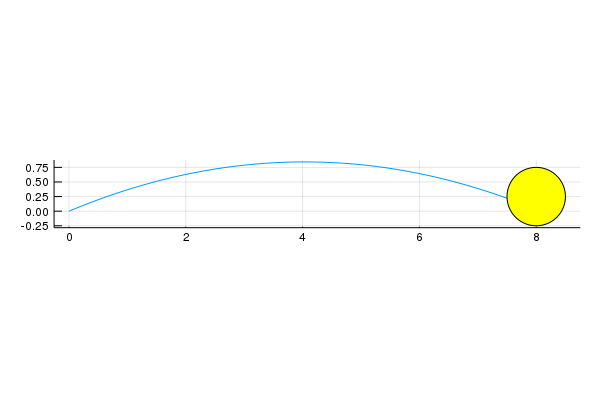

In [9]:
post_samples = rand((series, ball_pos, ball_radius), projectile_hits, 1000; alg = Replica)
series_, ball_pos_, ball_radius_ = ntranspose(post_samples)
i = rand(1:length(series_))
vizscene(series_[i], ball_pos_[i], ball_radius_[i])

### But For Causality

We will now use but-for causality to determine whether the angle of projection is the cause of the projectile hitting the ball

But-for causality looks for an intervention that invalidates the cause and the effect
Since we have soft constraints, we formulate this as an optimization problem
The following function sketches the implementation of but_for.  The full implementation can be found in our version

In [10]:
"""
`iscausebf(ω, c, e, iset; kwargs...)`

But-for causality.

Is `c` (provably) the actual cause of `e` in the causal world `ω`, allowing
interventions on variables defined in  `isset`
"""
function iscausebfsketch(ω::Omega.Ω, c::RandVar, e::RandVar, iset;
                   sizes = [length(i(ω)) for i in iset],
                   proj = identity, # maps reals to types of intervened vars
                   optargs...)
  @assert Bool(c(ω)) && Bool(e(ω)) "Both cause and effect must be true in ω"
  # Construct a loss function that is 1 when the constraint is satisfied
  loss = let rngs = splitvec(sizes), butfor = Omega.ciid(ω -> !c(ω) & !e(ω)), proj = proj
    function loss(vec, grad)
      # Since optimization requries vectors, we must do some book keeping
      replmap = Dict(iset[i] => proj(vec[rng]) for (i, rng) in enumerate(rngs))
      # In loss function we construct intervened mode where intervenable variables
      # in iset have been set to values under consideration
      butforint = replace(butfor, replmap)
      # Get a score of the degree tow hich the effect `e` stil holds (in log scale)
      Omega.logerr(butforint(ω))
    end
  end
  # optimize this loss function
  nlopt(loss, ω, iset, sizes; optargs...)
end

Main.##384.iscausebfsketch

Next, we must construct a causal world world where the condition is true (the projectile hits):

In [11]:
ωs = rand(Random.MersenneTwister(), defΩ(Replica), logerr(projectile_hits),  1000, Replica);

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


Take a single sample from this set and do a sanity check (the project really does hit)

In [12]:
ω = ωs[end]
Bool(projectile_hits(ω))

true

Finally, we can check but-for causality: in world ω, is value that θ takes in this world cause of prjectile hitting?

In [13]:
Omega.iscausebf(ω, θ ==ₛ θ(ω), projectile_hits, [θ], proj = first)

true

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*